In [8]:
import numpy as np
import soundfile as sf
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('../klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N))  # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x)  # safer to center ...
    xall[tone, :] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
xall[39]

array([ 0.05834337,  0.06289049,  0.06743761, ..., -0.02564101,
       -0.02756362, -0.02936415])

In [40]:
import pandas as pd
midi = pd.read_csv('../midi.txt', sep='\t', header=None, index_col=0, names=['midi', 'freq'])

,freq
midi,
108,4186.01
107,3951.07
106,3729.31
105,3520.00
104,3322.44
...,...
28,41.20
27,38.89
26,36.71


78
185
2796


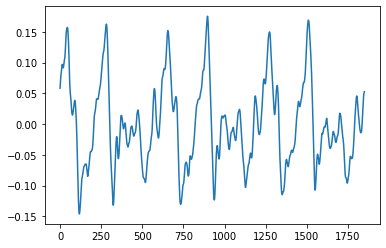

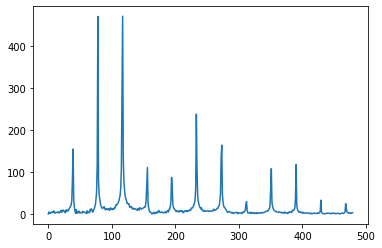

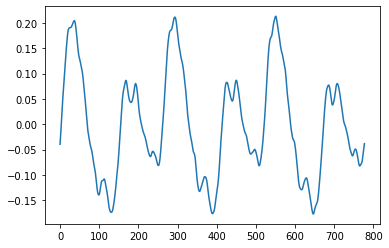

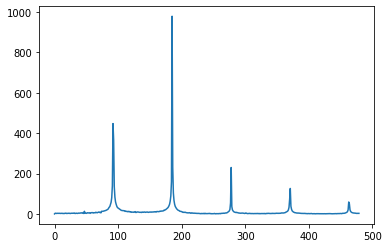

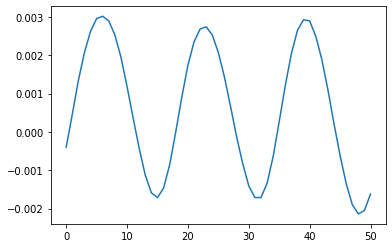

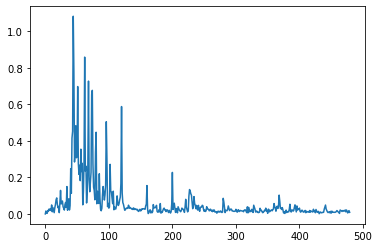

In [87]:
import matplotlib.pyplot as plt

freq = 48000
window = 15
names = ['a', 'b', 'c']

with open('../xkucha28.txt', 'r') as f:
    tones = list(map(int, f.read().strip().split(' ')))
    
    for i, tone in enumerate(tones):
        tone_freq = midi['freq'][tone]

        threePeriods = int((1/tone_freq)*48000 * 3)

        fft = np.abs(np.fft.fft(xall[tone]))

        print(np.argmax(
            fft[int(tone_freq) - window: int(tone_freq) + window]) + int(tone_freq) - window)

        plt.figure()
        plt.plot(xall[tone][:threePeriods])
        plt.figure()
        plt.plot(fft[:int(freq/100)])

        #np.correlate()

        sf.write(f'../audio/{names[i]}_orig.wav', xall[tone], freq)


In [6]:
import pandas as pd
with open('../skladba.txt', 'r') as f:
    song = pd.read_csv(f, sep=' ', header=None, names=['from', 'to', 'midi', 'volume'])

7200.0
